# **PT2 - ANÁLISIS DE LA RELACIÓN RENTABILIDAD-RIESGO Y MODELACIÓN**

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [20]:
# Leer archivo
df = pd.read_excel("datos_estudio_riesgovsrent.xlsx")
trad_df = pd.read_excel("fondo_tradicionales_riesgo.xlsx")
impact_df = pd.read_excel("fondo_impacto_riesgo.xlsx")

## **Exploración visual de la rentabilidad y el riesgo.**

In [21]:
# Filtrar columnas necesarias para graficar
df_plot = df[['tipo', 'IRR', 'riesgo']].dropna()

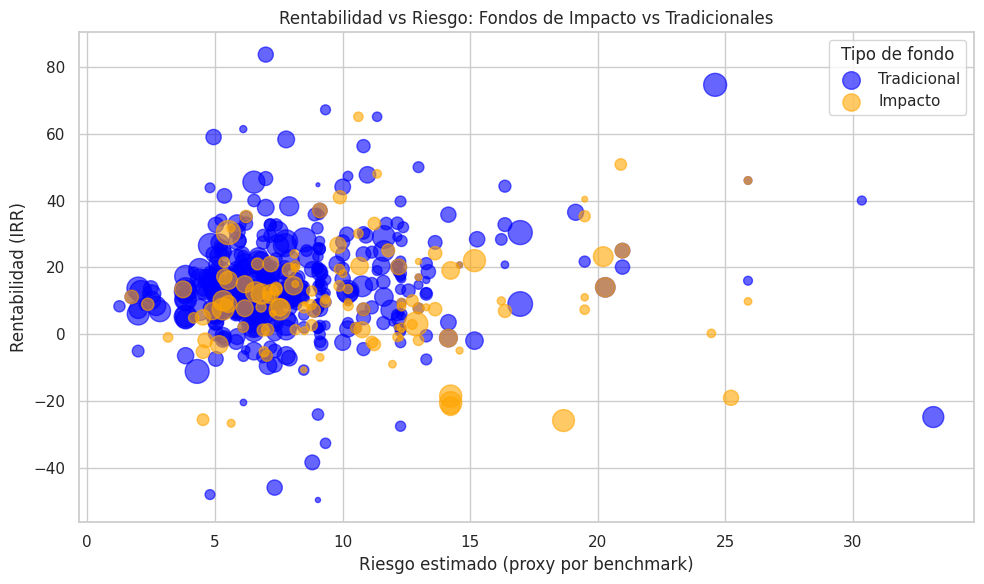

In [22]:
# Paleta de colores y estilo homogéneos
colores = {'tradicional': 'blue', 'impacto': 'orange'}
sns.set(style="whitegrid")

# Verificar si existe 'Fund Size' y crear tamaño si procede
if 'Fund Size' in df.columns:
    df_plot = df[['tipo', 'IRR', 'riesgo', 'Fund Size']].dropna().copy()
    df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5
else:
    df_plot = df[['ripo', 'IRR', 'riesgo']].dropna().copy()
    df_plot['size'] = 100  # tamaño fijo

# Figura
plt.figure(figsize=(10, 6))
plt.title("Rentabilidad vs Riesgo: Fondos de Impacto vs Tradicionales")

# Gráfico de dispersión
for fondo_tipo in ['tradicional', 'impacto']:
    tipo_df = df_plot[df_plot['tipo'] == fondo_tipo]
    if tipo_df.empty:
        continue

    plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                s=tipo_df['size'],
                color=colores[fondo_tipo],
                alpha=0.6,
                label=fondo_tipo.capitalize())

plt.xlabel("Riesgo estimado (proxy por benchmark)")
plt.ylabel("Rentabilidad (IRR)")
plt.legend(title="Tipo de fondo")
plt.tight_layout()
plt.show()


## **Regresión Lineal Simple por Tipo de Fondo**

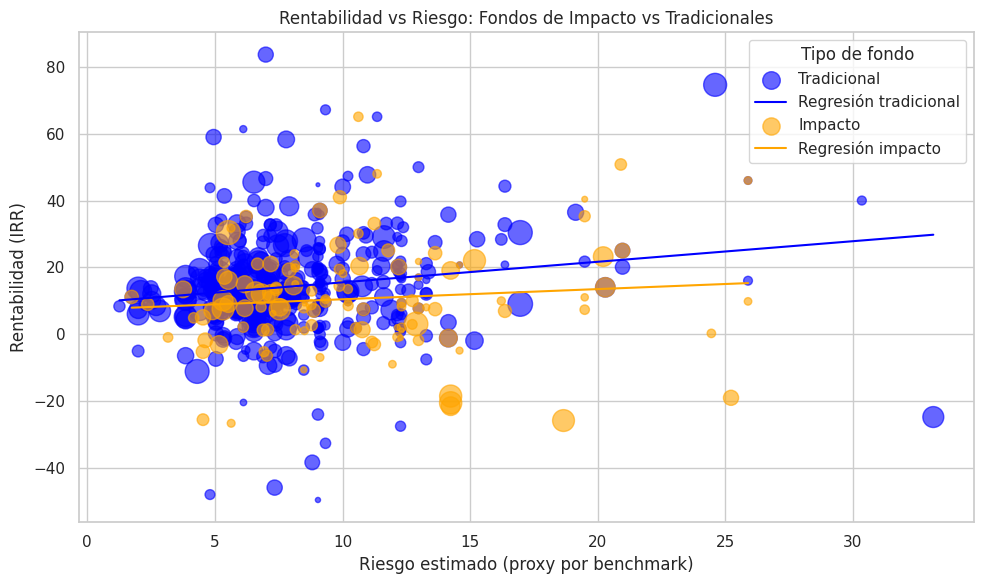

In [23]:
# Paleta de colores
colores = {'tradicional': 'blue', 'impacto': 'orange'}

# Estilo y figura
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title("Rentabilidad vs Riesgo: Fondos de Impacto vs Tradicionales")

# Si no tienes la columna 'size', puedes crearla
if 'Fund Size' in df_plot.columns:
    df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5
else:
    df_plot['size'] = 100

# Inicializar modelos fuera del bucle
modelo_trad = None
modelo_imp = None

# Dibujar dispersión y regresión para cada tipo de fondo
for fondo_tipo in ['tradicional', 'impacto']:
    tipo_df = df_plot[df_plot['tipo'] == fondo_tipo]
    if tipo_df.empty:
        continue

    # Gráfico de dispersión
    plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                s=tipo_df['size'],
                alpha=0.6,
                color=colores[fondo_tipo],
                label=fondo_tipo.capitalize())

    # Ajustar y graficar regresión lineal
    X = sm.add_constant(tipo_df['riesgo'])
    y = tipo_df['IRR']
    modelo = sm.OLS(y, X).fit()

    # Guardar modelo correspondiente
    if fondo_tipo == 'tradicional':
        modelo_trad = modelo
    else:
        modelo_imp = modelo

    # Graficar la regresión
    x_vals = np.linspace(tipo_df['riesgo'].min(), tipo_df['riesgo'].max(), 100)
    X_vals = sm.add_constant(x_vals)
    y_vals = modelo.predict(X_vals)
    plt.plot(x_vals, y_vals, color=colores[fondo_tipo], label=f"Regresión {fondo_tipo}")

# Etiquetas
plt.xlabel("Riesgo estimado (proxy por benchmark)")
plt.ylabel("Rentabilidad (IRR)")
plt.legend(title="Tipo de fondo")
plt.tight_layout()
plt.show()



=== Regresión para Fondos Tradicionales ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.12
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           0.000926
Time:                        01:04:00   Log-Likelihood:                -1784.9
No. Observations:                 435   AIC:                             3574.
Df Residuals:                     433   BIC:                             3582.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

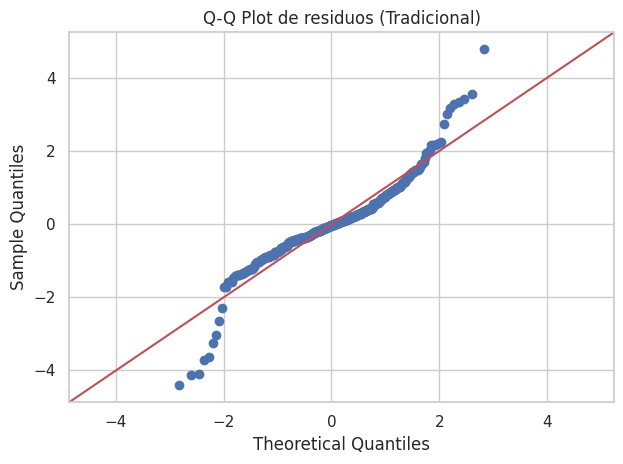

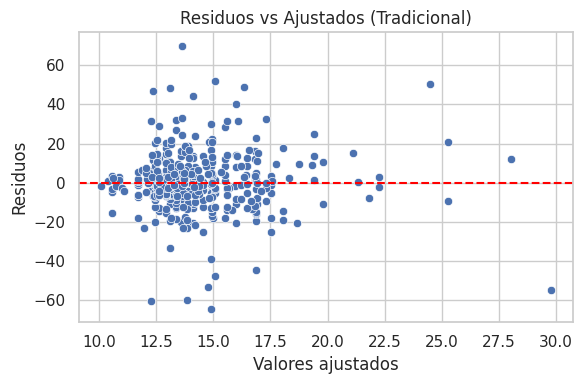

VIF Tradicional:
  Variable       VIF
0    const  5.503787
1   riesgo  1.000000


In [24]:
print("=== Regresión para Fondos Tradicionales ===")
print(modelo_trad.summary())

# Residuos
resid_trad = modelo_trad.resid
fitted_trad = modelo_trad.fittedvalues

# Q-Q Plot (normalidad)
sm.qqplot(resid_trad, line='45', fit=True)
plt.title('Q-Q Plot de residuos (Tradicional)')
plt.tight_layout()
plt.show()

# Homocedasticidad
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_trad, y=resid_trad)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados (Tradicional)')
plt.tight_layout()
plt.show()

# VIF (aunque con una sola variable explicativa no es relevante, se deja como estructura)
X_trad_vif = sm.add_constant(trad_df[['riesgo']].dropna())
vif_trad = pd.DataFrame()
vif_trad["Variable"] = X_trad_vif.columns
vif_trad["VIF"] = [variance_inflation_factor(X_trad_vif.values, i) for i in range(X_trad_vif.shape[1])]
print("VIF Tradicional:")
print(vif_trad)

=== Regresión para Fondos de Impacto ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.188
Date:                Tue, 01 Jul 2025   Prob (F-statistic):              0.278
Time:                        01:04:03   Log-Likelihood:                -497.27
No. Observations:                 120   AIC:                             998.5
Df Residuals:                     118   BIC:                             1004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

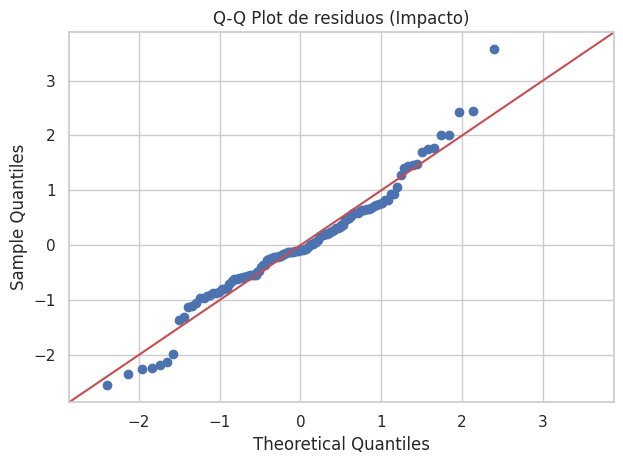

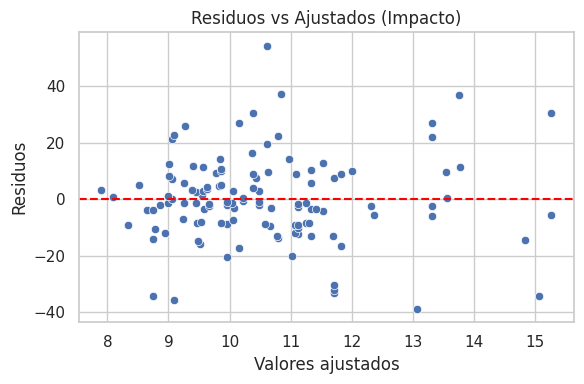

VIF Impacto:
  Variable       VIF
0    const  5.403366
1   riesgo  1.000000


In [25]:
print("=== Regresión para Fondos de Impacto ===")
print(modelo_imp.summary())

resid_imp = modelo_imp.resid
fitted_imp = modelo_imp.fittedvalues

sm.qqplot(resid_imp, line='45', fit=True)
plt.title('Q-Q Plot de residuos (Impacto)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_imp, y=resid_imp)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados (Impacto)')
plt.tight_layout()
plt.show()

X_imp_vif = sm.add_constant(impact_df[['riesgo']].dropna())
vif_imp = pd.DataFrame()
vif_imp["Variable"] = X_imp_vif.columns
vif_imp["VIF"] = [variance_inflation_factor(X_imp_vif.values, i) for i in range(X_imp_vif.shape[1])]
print("VIF Impacto:")
print(vif_imp)

## **Modelo de Regresión Lineal Múltiple**

In [26]:
# Convertir fechas
df['Open Date'] = pd.to_datetime(df['Open Date'], errors='coerce')
df['Close Date'] = pd.to_datetime(df['Close Date'], errors='coerce')

# Usar 31 diciembre 2024 como fecha de corte si el fondo sigue abierto
df['Fecha Corte'] = pd.to_datetime('2024-12-31')
df['End Date'] = df['Close Date'].fillna(df['Fecha Corte'])

# Calcular duración en años
df['duracion_fondo'] = (df['End Date'] - df['Open Date']).dt.days / 365.25

# Asegúrate de que no haya valores faltantes
reg_df = df[['IRR', 'riesgo', 'tipo', 'duracion_fondo', 'Fund Size']].dropna().copy()

# Codificar 'tipo' como dummy: 0 = tradicional, 1 = impacto
reg_df['tipo'] = reg_df['tipo'].map({'tradicional': 0, 'impacto': 1})

# Transformar el tamaño del fondo con logaritmo
reg_df['log_fund_size'] = np.log(reg_df['Fund Size'])

# Modelo de regresión lineal SIN Vintage y CON duración
modelo = smf.ols(
    formula="IRR ~ riesgo + tipo + log_fund_size + duracion_fondo",
    data=reg_df
).fit()

# Resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.719
Date:                Tue, 01 Jul 2025   Prob (F-statistic):             0.0295
Time:                        01:04:06   Log-Likelihood:                -1533.5
No. Observations:                 379   AIC:                             3077.
Df Residuals:                     374   BIC:                             3097.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.6458      4.206      3.

## **Análisis por grupos de madurez**


=== REGRESIÓN PARA <50% devuelto | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.257
Date:                Tue, 01 Jul 2025   Prob (F-statistic):            0.00408
Time:                        01:25:57   Log-Likelihood:                -191.34
No. Observations:                  43   AIC:                             386.7
Df Residuals:                      41   BIC:                             390.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


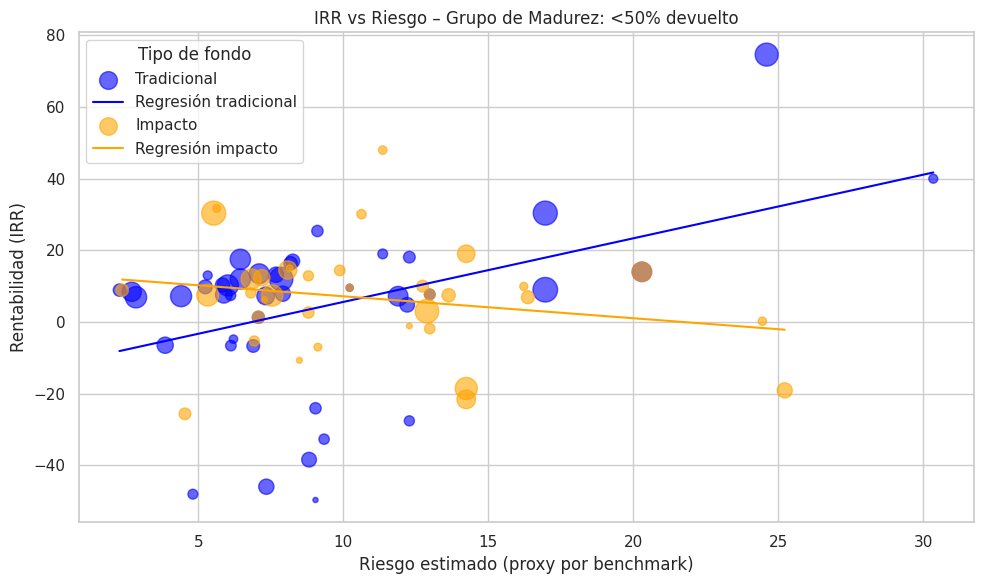


=== REGRESIÓN PARA 50–99% | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.839
Date:                Tue, 01 Jul 2025   Prob (F-statistic):             0.0333
Time:                        01:25:58   Log-Likelihood:                -175.34
No. Observations:                  45   AIC:                             354.7
Df Residuals:                      43   BIC:                             358.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

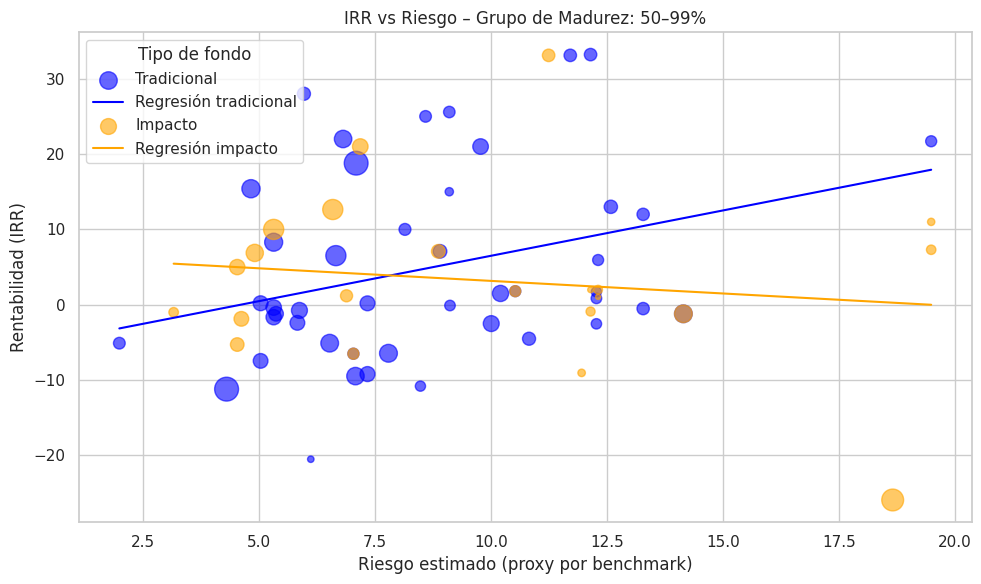


=== REGRESIÓN PARA 100–149% | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.133
Date:                Tue, 01 Jul 2025   Prob (F-statistic):             0.0801
Time:                        01:25:58   Log-Likelihood:                -318.11
No. Observations:                  92   AIC:                             640.2
Df Residuals:                      90   BIC:                             645.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


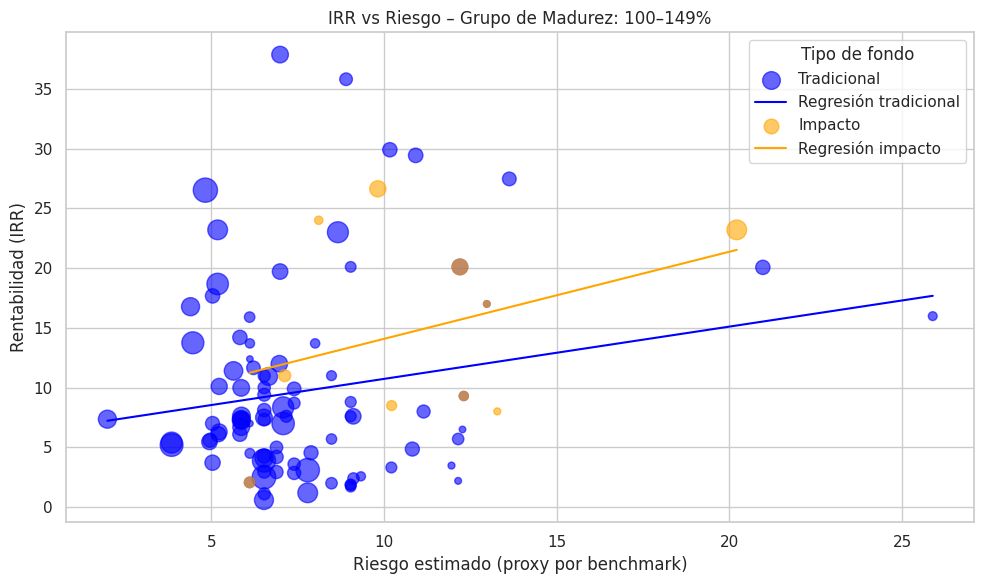


=== REGRESIÓN PARA 150%+ | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     7.369
Date:                Tue, 01 Jul 2025   Prob (F-statistic):            0.00724
Time:                        01:25:59   Log-Likelihood:                -753.92
No. Observations:                 194   AIC:                             1512.
Df Residuals:                     192   BIC:                             1518.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

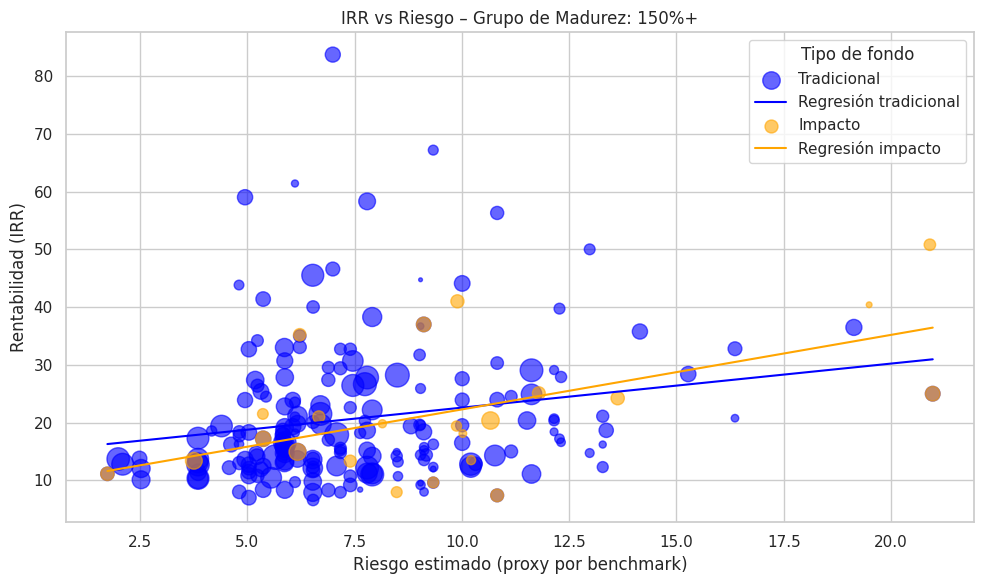

In [29]:
# Crear grupos de madurez por DPI
def clasificar_dpi(dpi):
    if pd.isna(dpi):
        return None
    elif dpi < 0.5:
        return "<50% devuelto"
    elif dpi < 1:
        return "50–99%"
    elif dpi < 1.5:
        return "100–149%"
    else:
        return "150%+"

df['grupo_distribuido'] = df['DPI'].apply(clasificar_dpi)

# Preparar datos para análisis
df_plot = df[['tipo', 'IRR', 'riesgo', 'grupo_distribuido', 'Fund Size']].dropna().copy()
df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5  # escala del tamaño del punto

# Definir grupos y colores
grupos = ['<50% devuelto', '50–99%', '100–149%', '150%+']
colores = {'tradicional': 'blue', 'impacto': 'orange'}

# Loop por grupo de madurez
for grupo in grupos:
    subset = df_plot[df_plot['grupo_distribuido'] == grupo]
    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    plt.title(f"IRR vs Riesgo – Grupo de Madurez: {grupo}")

    for tipo in ['tradicional', 'impacto']:
        tipo_df = subset[subset['tipo'] == tipo]
        if tipo_df.empty:
            continue

        # Dispersión
        plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                    s=tipo_df['size'],
                    color=colores[tipo],
                    alpha=0.6,
                    label=tipo.capitalize())

        # Regresión si hay suficientes datos
        if len(tipo_df) >= 5:
            X = sm.add_constant(tipo_df['riesgo'])
            y = tipo_df['IRR']
            modelo = sm.OLS(y, X).fit()

            x_vals = np.linspace(tipo_df['riesgo'].min(), tipo_df['riesgo'].max(), 100)
            X_vals = sm.add_constant(x_vals)
            y_vals = modelo.predict(X_vals)
            plt.plot(x_vals, y_vals, color=colores[tipo], label=f"Regresión {tipo}")

            print(f"\n=== REGRESIÓN PARA {grupo} | {tipo.upper()} ===")
            print(modelo.summary())
        else:
            print(f"\n[!] Grupo {grupo} | {tipo.upper()} no tiene suficientes datos ({len(tipo_df)}) para regresión.")

    plt.xlabel("Riesgo estimado (proxy por benchmark)")
    plt.ylabel("Rentabilidad (IRR)")
    plt.legend(title="Tipo de fondo")
    plt.tight_layout()
    plt.show()
